# Applied Data Science Capstone- Battle of the Neighborhoods
## Analyzing the Neighborhoods of Seattle, Washington

### Introduction/ Business Problem:

With a deadly virus infecting the planet, most jobs have gone remote, thus giving people an option to move farther away from the office. We have seen a trend where people are moving away from expensive big cities to the suburbs or even to other states where there is no income tax, such as Washington and Texas. 

I am currently living in Pleasanton, California, which is to the east of San Francisco Bay Area. I enjoy living here because of the proximity to a variety of grocery stores, parks, and international cuisine. It also has a low crime rate. But it's also very expensive to live here. So, I'd like to move to Seattle in the state of Washington, USA but I'd like to live in a comparable neighborhood to where I am now. 

The aim of the project is to apply the skills learned in the Coursera course to find the safest neighborhood in Seattle, surrounded by amenities similar to the ones in my current location. This will be determined by analyzing the number of crimes per neighborhood, clustering neighborhoods using k-means, and exploring the top common venues in the safest neighborhoods. 

This exercise may also be of interest to anyone living in an expensive city looking to move to Seattle, Washington.

### Data

The crime data in Seattle was open source and available for download directly from the Seattle Police Department’s [website](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5). It contained the crime offense, the crime offense category, the district where the crime took place, and the longitude and latitude of the crime location. 

I also obtained a list of Seattle’s districts and neighborhoods by web scraping a [Wikipedia page](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle) using BeautifulSoup. However, this dataset lacked the geographical coordinates. So, I used geocoder to obtain the latitude and longitude coordinates for each Seattle neighborhood.

To get venue information in each neighborhood, I called the [Foursquare API](https://foursquare.com/developers/apps). This gave me a dataset containing the venue name, latitude and longitude coordinates of the venue location, and the venue category.

#### Let's first install the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if geopy package is not installed
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut 

import requests # library to handle requests

#!pip install BeautifulSoup4
from bs4 import BeautifulSoup # for web scraping

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import seaborn to make pretty plots
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium package is not installed
#!pip install folium
import folium # map-rendering library

print('Libraries imported.')

Libraries imported.


## 1. Gather Seattle neighborhood and district information from the web

- Scrape wikipedia page for Seattle neighborhoods and save as csv file
- Use geocoder to get latitude and longitude coordinates
- Export dataframe into csv for future use
- (Read the csv file and put into a dataframe)
- data cleanup- delete the rows where coordinates couldn't be found
- Visualize the map of these neighborhoods

#### First, let's scrape the wikipedia page for a list of Seattle's neighborhoods and districts

In [2]:
#scrape wikipedia for Seattle neighborhoods
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle'
wiki_html = requests.get(url).text
soup = BeautifulSoup(wiki_html, 'html.parser')

data = []
for tr in soup.tbody.find_all('tr'):
    data.append([ td.get_text().strip() for td in tr.find_all('td') ])

data = data[1:128]

data_SEAneigh = []
data_SEAdistrict = []

for row in range(len(data)):
    data_SEAneigh.append(data[row][0])
    data_SEAdistrict.append(data[row][1])

#### Then, we need to clean up the dataset

In [3]:
# clean up Seattle neighborhood dataset of anything written in brackets
for row in range(len(data_SEAdistrict)):
    if '[' in data_SEAdistrict[row]:
        index_remove = data_SEAdistrict[row].index('[')
        data_SEAdistrict[row] = data_SEAdistrict[row][0:index_remove]
        
for row in range(len(data_SEAneigh)):
    if '[' in data_SEAneigh[row]:
        index_remove = data_SEAneigh[row].index('[')
        data_SEAneigh[row] = data_SEAneigh[row][0:index_remove]

In [4]:
# create column names and put Seattle dataset into a pandas dataframe
SEAdata = pd.DataFrame(columns=['Neighborhood','District'])
for item in range(len(data_SEAneigh)):
    SEAdata = SEAdata.append({'Neighborhood': data_SEAneigh[item],
                             'District': data_SEAdistrict[item]}, ignore_index=True)

SEAdata.head()

,Neighborhood,District
0,North Seattle,Seattle
1,Broadview,North Seattle
2,Bitter Lake,North Seattle
3,North Beach / Blue Ridge,North Seattle
4,Crown Hill,North Seattle


#### To bypass the webscraping process in the future, I have saved the dataframe to a csv. Now, we can import the list of Seattle neighborhoods and districts from a csv directly to save time.

In [7]:
# Save Seattle neighborhoods to csv
SEAdata.to_csv(r'D:\seattle-wa-neighborhoods.csv', index = False)

In [11]:
# TO IMPORT THE CLEANED SEATTLE DATAFRAME FROM THE GETGO
# define the dataframe columns
column_names = ['Neighborhood', 'District']
# load the dataset
wa_data = pd.read_csv(r'D:\seattle-wa-neighborhoods.csv', names=column_names)
#print the dataset
wa_data.head(10)

,Neighborhood,District
0,Neighborhood,District
1,North Seattle,Seattle
2,Broadview,North Seattle
3,Bitter Lake,North Seattle
4,North Beach / Blue Ridge,North Seattle
5,Crown Hill,North Seattle
6,Greenwood,North Seattle
7,Northgate,North Seattle
8,Haller Lake,Northgate
9,Pinehurst,Northgate


#### With this dataframe of neighborhoods and districts, we will get the latitude and longitude coordinates by using geocoder.

In [12]:
# define function lat_lng to return the latitude and longitude coordinates for an address/ neighborhood
import geocoder
def get_latlng(address):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Washington'.format(address)) #geocoder.google is replaced with arcgis to make it go faster
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [13]:
# declare latitude and longitude as an empty list to initialize
latitude = []
longitude = []

# Use function get_latlng to get latitude and longitude for every neighborhood in the dataset  
for address in (wa_data["Neighborhood"]):
    if get_latlng(address) != None:
        loc = get_latlng(address)
        # returned coordinates returned are stored into the latitude and longitude list
        latitude.append(loc[0])
        longitude.append(loc[1])
        
        #if coordinates are not found, insert "NaN" indicating missing value
    else:
        print(i + ", WA")
        latitude.append(np.nan)
        longitude.append(np.nan)

#### We can now append the geographical coordinates to the dataframe and clean up the dataset by dropping any rows where coordinates weren't found.

In [14]:
# Add latitude and longitude data to dataframe
wa_data["Latitude"] = latitude
wa_data["Longitude"] = longitude

In [15]:
#Drop rows where coordinates weren't found
wa_data.dropna(subset=['Latitude'], inplace=True)
wa_data.reset_index(drop=True, inplace=True)
wa_data.head()

,Neighborhood,District,Latitude,Longitude
0,Neighborhood,District,12.516990,123.749150
1,North Seattle,Seattle,47.643724,-122.302937
2,Broadview,North Seattle,47.722380,-122.364980
3,Bitter Lake,North Seattle,47.718680,-122.350300
4,North Beach / Blue Ridge,North Seattle,47.700440,-122.384180


#### Calling geocoder on all the neighborhoods took a lot of time, so to save time in the future I have saved the dataframe to a csv. Now, we can import the list of Seattle neighborhoods and districts, as well as their geographical coordinates, from a csv.

In [16]:
# Save dataframe to csv
wa_data.to_csv(r'D:\seattle-wa-neighborhoods-geo.csv', index = False)

In [17]:
# TO IMPORT WASHINGTON DATAFRAME WITH COORDINATES FROM THE GETGO
wa_data = pd.read_csv(r'D:\seattle-wa-neighborhoods-geo.csv')
wa_data.dropna(subset=['Latitude'], inplace=True)
wa_data.reset_index(drop=True, inplace=True)
wa_data.head()

,Neighborhood,District,Latitude,Longitude
0,Neighborhood,District,12.516990,123.749150
1,North Seattle,Seattle,47.643724,-122.302937
2,Broadview,North Seattle,47.722380,-122.364980
3,Bitter Lake,North Seattle,47.718680,-122.350300
4,North Beach / Blue Ridge,North Seattle,47.700440,-122.384180


#### This is how many neighborhoods and districts there are in the dataframe.

In [18]:
# Print the number of districts and neighborhoods in the dataframe
print('The dataframe has {} districts and {} neighborhoods.'.format(
        len(wa_data['District'].unique()),
        wa_data.shape[0]
    )
)

The dataframe has 33 districts and 128 neighborhoods.


#### Let's create a map to visualize all these neighborhoods.

In [20]:
# Get the geographical coordinates of Seattle
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="seattle_explorer")
location_seattle = geolocator.geocode(address)
latitude_seattle = location_seattle.latitude
longitude_seattle = location_seattle.longitude
print('The geographical coordinates of Seattle are {}, {}.'.format(latitude_seattle, longitude_seattle))

The geographical coordinates of Seattle are 47.6038321, -122.3300624.


In [21]:
# Create map of King County using latitude and longitude values
map_kingcounty = folium.Map(location=[latitude_seattle, longitude_seattle], zoom_start=10)

# add markers to map
for lat, lng, city, neighborhood in zip(wa_data['Latitude'], wa_data['Longitude'], wa_data['District'], wa_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kingcounty)  
    
map_kingcounty

## 2. Get Seattle crime data
The Seattle crime dataset was downloaded from the Seattle Police Department website directly and saved as a csv file on my local drive. Now, I just have to import it and see what's in it.

In [22]:
crime = pd.read_csv(r'D:\SPD_Crime_Data__8-2019-to-present.csv')
crime.head()

,Report Number,Offense ID,Offense Start DateTime,Offense End DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Precinct,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
0,2020-232722,14749627332,8/5/2020 22:03,8/5/2020 22:03,8/6/2020 1:10,A,PROPERTY,BURGLARY/BREAKING&ENTERING,Burglary/Breaking & Entering,220,E,E,E1,CAPITOL HILL,6XX BLOCK OF BELMONT AVE E,-122.324039,47.624705
1,2020-232740,14746508904,8/5/2020 22:45,8/5/2020 23:30,8/5/2020 23:31,A,PERSON,ASSAULT OFFENSES,Simple Assault,13B,E,C,C3,CENTRAL AREA/SQUIRE PARK,9XX BLOCK OF 25TH AVE,-122.300138,47.610795
2,2020-232748,14746068011,8/5/2020 21:00,8/5/2020 23:00,8/5/2020 23:26,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,E,E,E2,CAPITOL HILL,15XX BLOCK OF 12TH AVE,-122.316845,47.614684
3,2020-232689,14745070199,8/5/2020 21:10,NaN,8/5/2020 22:59,A,PERSON,ASSAULT OFFENSES,Simple Assault,13B,SW,F,F1,NORTH DELRIDGE,54XX BLOCK OF DELRIDGE WAY SW,-122.362975,47.552820
4,2020-232654,14742137960,8/4/2020 0:00,8/4/2020 23:59,8/5/2020 22:18,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,W,Q,Q2,QUEEN ANNE,24XX BLOCK OF 4TH AVE W,-122.362259,47.640821


#### Let's check the size of the dataset.

In [23]:
# check the number of rows and columns
crime.shape

(76931, 17)

#### The dataset is rather large with a lot of columns we don't need. So, let's do some data cleaning.

In [24]:
# Keep only the columns I'm interested in
crime = crime[['Offense Parent Group','Offense','MCPP','Latitude','Longitude']]
# rename the column titles
crime.rename(columns={"Offense Parent Group": "Offense Category", "MCPP": "District"}, inplace=True)
crime.head()

,Offense Category,Offense,District,Latitude,Longitude
0,BURGLARY/BREAKING&ENTERING,Burglary/Breaking & Entering,CAPITOL HILL,47.624705,-122.324039
1,ASSAULT OFFENSES,Simple Assault,CENTRAL AREA/SQUIRE PARK,47.610795,-122.300138
2,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,CAPITOL HILL,47.614684,-122.316845
3,ASSAULT OFFENSES,Simple Assault,NORTH DELRIDGE,47.552820,-122.362975
4,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,QUEEN ANNE,47.640821,-122.362259


In [25]:
print("The crime dataset has ", str(crime.shape[0]), " records with ", str(len(crime["Offense"].unique()))," types of offenses in ", str(len(crime["District"].unique())), " districts.")

The crime dataset has  76931  records with  55  types of offenses in  59  districts.


In [26]:
# Check if there are any missing values in any of the rows
missingdata = crime.isnull()
for column in missingdata.columns.values.tolist():
    print(column)
    print(missingdata[column].value_counts())
    print("")

Offense Category
False    76931
Name: Offense Category, dtype: int64

Offense
False    76931
Name: Offense, dtype: int64

District
False    76931
Name: District, dtype: int64

Latitude
False    76931
Name: Latitude, dtype: int64

Longitude
False    76931
Name: Longitude, dtype: int64



## 3. Exploratory analysis of crime in Seattle
#### Let's look at how many times each offense occurred in our dataset.

In [27]:
# looking at the count per offense
crime["Offense"].value_counts()

Theft From Motor Vehicle                       10035
Identity Theft                                  9442
Burglary/Breaking & Entering                    8981
All Other Larceny                               6261
Destruction/Damage/Vandalism of Property        6111
Simple Assault                                  5164
Motor Vehicle Theft                             4387
Shoplifting                                     3881
Trespass of Real Property                       3224
Intimidation                                    3011
Aggravated Assault                              2769
Theft From Building                             2048
Theft of Motor Vehicle Parts or Accessories     1720
Robbery                                         1485
Driving Under the Influence                     1269
Drug/Narcotic Violations                        1217
Credit Card/Automated Teller Machine Fraud       923
False Pretenses/Swindle/Confidence Game          758
Stolen Property Offenses                      

#### Now let's break it down by district. How many times have each offense occurred per district?

In [28]:
# Looking at the number of crimes per offense by district
crime_dist = pd.DataFrame(crime.groupby(['District','Offense']).size().rename('Count of Offense').reset_index())
crime_dist.head()

,District,Offense,Count of Offense
0,ALASKA JUNCTION,Aggravated Assault,35
1,ALASKA JUNCTION,All Other Larceny,99
2,ALASKA JUNCTION,Bad Checks,2
3,ALASKA JUNCTION,Burglary/Breaking & Entering,166
4,ALASKA JUNCTION,Counterfeiting/Forgery,7


In [29]:
# Make a pivot table of the count per offense by district
crime_pivot = crime_dist.pivot_table("Count of Offense","District","Offense")

In [30]:
# Make a Total column that adds up the total count of offenses per district
crime_pivot["Total"] = crime_pivot.sum(axis=1)
crime_pivot.head()

Offense,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,Curfew/Loitering/Vagrancy Violations,Destruction/Damage/Vandalism of Property,Driving Under the Influence,Drug Equipment Violations,Drug/Narcotic Violations,Drunkenness,Embezzlement,Extortion/Blackmail,False Pretenses/Swindle/Confidence Game,"Family Offenses, Nonviolent",Fondling,Hacking/Computer Invasion,"Human Trafficking, Commercial Sex Acts","Human Trafficking, Involuntary Servitude",Identity Theft,Impersonation,Intimidation,Justifiable Homicide,Kidnapping/Abduction,Liquor Law Violations,Motor Vehicle Theft,Murder & Nonnegligent Manslaughter,Negligent Manslaughter,Peeping Tom,Pocket-picking,Pornography/Obscene Material,Prostitution,Purchasing Prostitution,Purse-snatching,Rape,Robbery,Sexual Assault With An Object,Shoplifting,Simple Assault,Sodomy,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud,Total
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ALASKA JUNCTION,35.0,99.0,NaN,NaN,NaN,2.0,NaN,166.0,7.0,17.0,NaN,106.0,34.0,NaN,7.0,NaN,1.0,1.0,9.0,1.0,3.0,2.0,NaN,NaN,231.0,2.0,42.0,NaN,NaN,1.0,90.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,3.0,18.0,NaN,40.0,73.0,2.0,NaN,2.0,55.0,NaN,120.0,37.0,29.0,6.0,NaN,8.0,1252.0
ALKI,9.0,44.0,NaN,NaN,NaN,NaN,NaN,38.0,1.0,4.0,NaN,24.0,14.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,NaN,NaN,99.0,1.0,28.0,NaN,1.0,NaN,14.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,21.0,2.0,NaN,NaN,5.0,NaN,41.0,5.0,6.0,1.0,1.0,6.0,373.0
BALLARD NORTH,23.0,151.0,NaN,5.0,NaN,4.0,NaN,165.0,9.0,22.0,NaN,112.0,34.0,NaN,7.0,NaN,NaN,3.0,18.0,1.0,3.0,2.0,NaN,NaN,528.0,3.0,38.0,NaN,NaN,1.0,124.0,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,6.0,18.0,NaN,34.0,54.0,1.0,NaN,3.0,35.0,NaN,257.0,52.0,15.0,2.0,1.0,18.0,1752.0
BALLARD SOUTH,76.0,314.0,NaN,5.0,NaN,4.0,NaN,485.0,26.0,45.0,2.0,230.0,26.0,NaN,22.0,NaN,4.0,1.0,16.0,3.0,6.0,2.0,NaN,NaN,275.0,1.0,96.0,NaN,3.0,1.0,193.0,1.0,NaN,NaN,8.0,1.0,NaN,NaN,NaN,7.0,42.0,NaN,194.0,124.0,NaN,1.0,22.0,67.0,2.0,492.0,89.0,100.0,8.0,1.0,9.0,3004.0
BELLTOWN,99.0,114.0,NaN,1.0,NaN,1.0,NaN,259.0,9.0,19.0,NaN,159.0,19.0,NaN,54.0,NaN,2.0,3.0,18.0,1.0,6.0,1.0,NaN,NaN,105.0,3.0,99.0,NaN,5.0,NaN,24.0,NaN,NaN,1.0,9.0,NaN,NaN,NaN,NaN,7.0,50.0,2.0,32.0,204.0,3.0,NaN,11.0,78.0,1.0,249.0,8.0,79.0,16.0,NaN,11.0,1762.0


#### Let's look at the descriptive statistics of th crime dataset in Seattle.

In [31]:
# get descriptive statistics of crime pivot table
crime_pivot.describe()

Offense,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,Curfew/Loitering/Vagrancy Violations,Destruction/Damage/Vandalism of Property,Driving Under the Influence,Drug Equipment Violations,Drug/Narcotic Violations,Drunkenness,Embezzlement,Extortion/Blackmail,False Pretenses/Swindle/Confidence Game,"Family Offenses, Nonviolent",Fondling,Hacking/Computer Invasion,"Human Trafficking, Commercial Sex Acts","Human Trafficking, Involuntary Servitude",Identity Theft,Impersonation,Intimidation,Justifiable Homicide,Kidnapping/Abduction,Liquor Law Violations,Motor Vehicle Theft,Murder & Nonnegligent Manslaughter,Negligent Manslaughter,Peeping Tom,Pocket-picking,Pornography/Obscene Material,Prostitution,Purchasing Prostitution,Purse-snatching,Rape,Robbery,Sexual Assault With An Object,Shoplifting,Simple Assault,Sodomy,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud,Total
count,59.000000,59.000000,15.000000,40.000000,2.0,33.000000,1.0,59.000000,52.000000,55.000000,15.000000,59.000000,58.000000,29.000000,55.000000,3.000000,30.000000,35.000000,57.000000,35.000000,49.000000,32.000000,9.000000,1.0,59.000000,44.000000,59.000000,2.0,42.000000,21.000000,59.000000,22.000000,1.0,13.000000,27.000000,20.00000,4.000000,6.000000,16.000000,50.000000,58.000000,24.000000,53.000000,57.000000,34.000000,3.0,51.000000,55.000000,18.000000,59.000000,58.000000,58.000000,55.000000,17.000000,53.000000,59.000000
mean,46.932203,106.118644,1.600000,3.650000,1.0,2.242424,1.0,152.220339,8.288462,16.781818,1.933333,103.576271,21.879310,2.103448,22.127273,1.333333,2.900000,3.000000,13.298246,1.885714,4.448980,2.375000,1.777778,1.0,160.033898,2.909091,51.033898,1.0,3.666667,2.714286,74.355932,1.681818,1.0,1.461538,6.777778,2.20000,20.250000,11.500000,2.312500,5.820000,25.603448,1.875000,73.226415,90.596491,2.411765,1.0,12.215686,37.236364,1.500000,170.084746,29.655172,55.586207,10.909091,1.117647,7.584906,1303.915254
std,51.503888,89.308278,0.910259,2.787794,0.0,1.714466,NaN,168.898671,9.032266,17.035574,2.120198,92.861819,19.668371,2.335209,41.936926,0.577350,2.951913,2.222876,13.314821,1.693785,3.979433,1.263635,1.641476,NaN,157.781382,2.726427,52.623243,0.0,2.885343,4.797321,56.479097,0.994574,NaN,1.664101,10.270695,1.43637,34.538626,18.063776,2.358495,5.857805,32.820051,1.153916,128.792266,100.748424,2.324020,0.0,14.715045,46.833022,0.618347,164.859531,26.075835,85.864445,15.136750,0.332106,5.641310,1212.340616
min,2.000000,6.000000,1.000000,1.000000,1.0,1.000000,1.0,2.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,2.000000,1.000000,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.0,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,35.000000
25%,14.500000,42.000000,1.000000,1.000000,1.0,1.000000,1.0,38.500000,2.000000,5.000000,1.000000,36.000000,9.000000,1.000000,4.000000,1.000000,1.000000,1.000000,4.000000,1.000000,2.000000,1.000000,1.000000,1.0,49.000000,1.000000,18.500000,1.0,1.250000,1.000000,28.000000,1.000000,1.0,1.000000,2.000000,1.00000,2.500000,2.500000,1.000000,2.000000,6.250000,1.000000,6.000000,25.000000,1.000000,1.0,4.000000,7.000000,1.000000,53.000000,10.500000,9.500000,3.000000,1.000000,3.000000,491.000000
50%,28.000000,81.000000,1.000000,4.000000,1.0,2.000000,1.0,86.000000,5.000000,9.000000,1.000000,75.000000,16.500000,1.000000,7.000000,1.000000,1.500000,2.000000,8.000000,1.000000,3.000000,2.000000,1.000000,1.0,103.000000,2.000000,32.000000,1.0,3.000000,1.000000,55

#### Hmm that was hard to visualize. Maybe turning it into a box plot would make it easier to read.

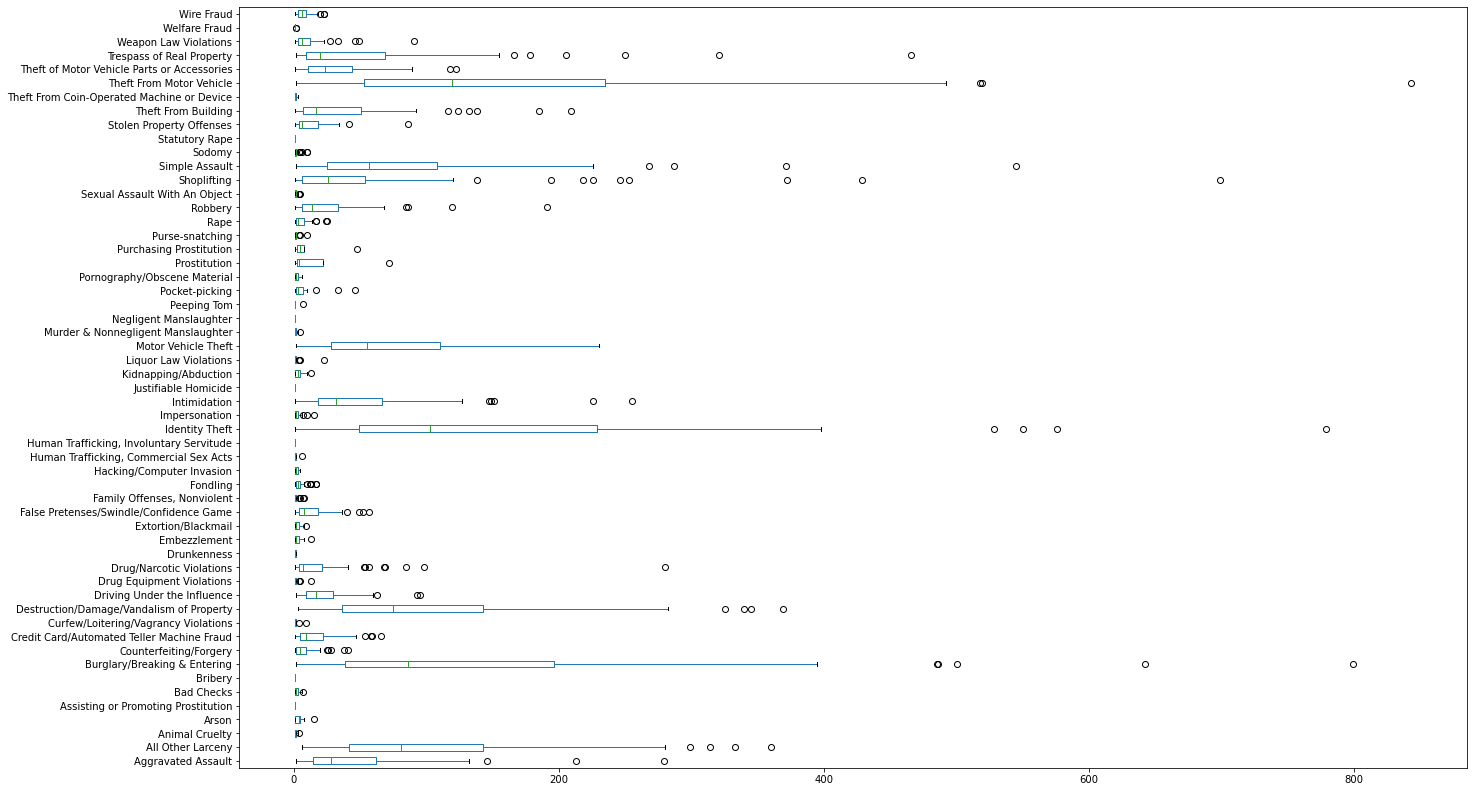

In [32]:
# get boxplot to easily visualize the descriptive stats of each crime
crime_pivot0 = crime_pivot.iloc[:,:-1] #delete the totals column
crime_pivot0.plot(kind='box', vert=False, figsize=[22,14])

#### Which Seattle districts should I stay away from because they had the most crime?

In [33]:
# Sort the crime pivot table by the Totals column from highest number of offenses to lowest
crime_sort = pd.DataFrame(crime_pivot['Total'].sort_values(ascending=False))
# show the top 10 districts with the highest number of offenses
print("These are the top 10 districts with the highest number of offenses:")
crime_sort.head(10)

These are the top 10 districts with the highest number of offenses:


,Total
District,
DOWNTOWN COMMERCIAL,5344.0
QUEEN ANNE,4481.0
CAPITOL HILL,4464.0
NORTHGATE,3978.0
SLU/CASCADE,3235.0
UNIVERSITY,3192.0
ROOSEVELT/RAVENNA,3071.0
BALLARD SOUTH,3004.0
FIRST HILL,2548.0


#### Which Seattle districts are the safest because they had the least amount of crime?

In [34]:
#show the bottom 10 districts with the lowest number of offenses
print("These are the 10 districts with the lowest number of offenses:")
crime_sort.tail(10)

These are the 10 districts with the lowest number of offenses:


,Total
District,
ALKI,373.0
MADISON PARK,320.0
HILLMAN CITY,307.0
SOUTH BEACON HILL,294.0
SOUTH DELRIDGE,260.0
GENESEE,190.0
EASTLAKE - EAST,119.0
PIGEON POINT,86.0
COMMERCIAL DUWAMISH,49.0


#### Now we can combine the safest and unsafest districts in a bar chart to better visualize it.

In [35]:
# Create new dataframe with the top and bottom 10 districts according to total number of crimes
crime_sort_hilo = pd.concat([crime_sort.head(10), crime_sort.tail(10)]).sort_values(by=["Total"], ascending=False)
crime_sort_hilo

,Total
District,
DOWNTOWN COMMERCIAL,5344.0
QUEEN ANNE,4481.0
CAPITOL HILL,4464.0
NORTHGATE,3978.0
SLU/CASCADE,3235.0
UNIVERSITY,3192.0
ROOSEVELT/RAVENNA,3071.0
BALLARD SOUTH,3004.0
FIRST HILL,2548.0


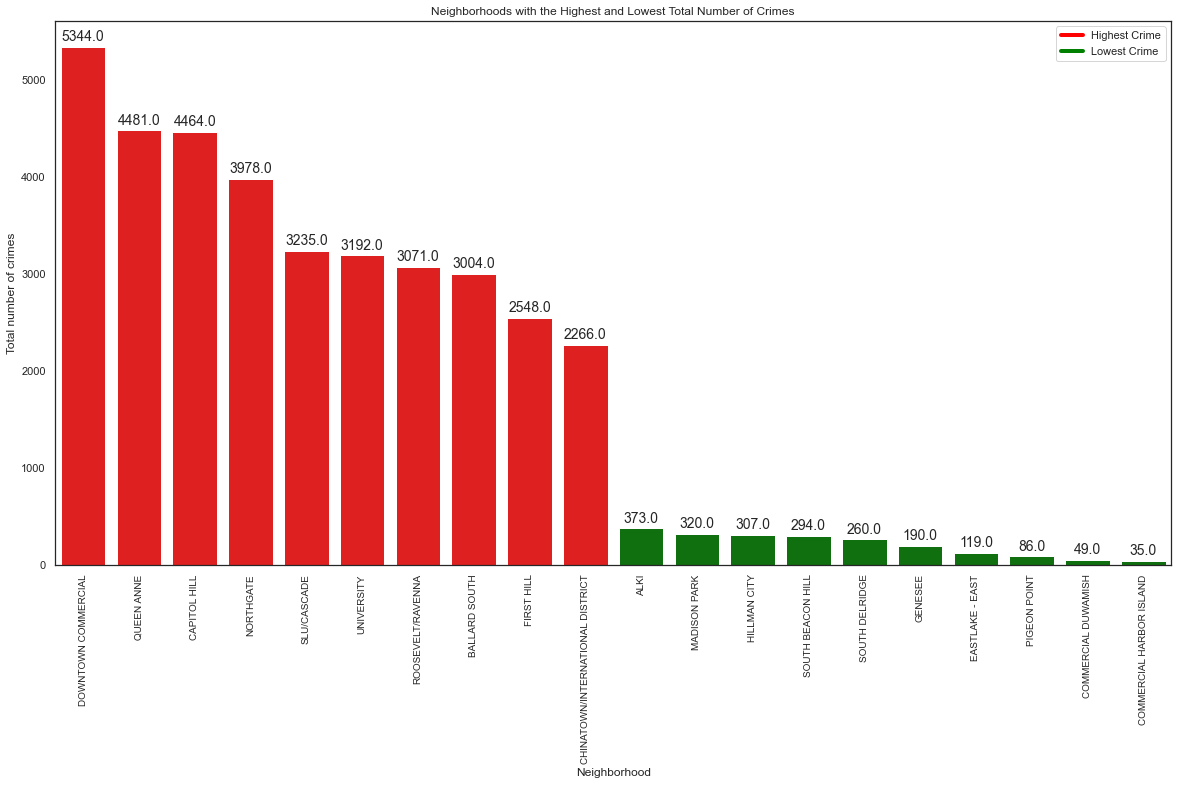

In [36]:
# Visualize the top and bottom 10 districts by number of total crimes

import seaborn as sns
from matplotlib.lines import Line2D

sns.set(style="white")

# create the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))
colors = ["red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "green", "green", "green", "green", "green", "green", "green", "green", "green", "green", "green"]
custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4)]

# plot the graph of Total number of crimes in each neighborhood
barplot_alltypes = sns.barplot(x=crime_sort_hilo.index, y="Total", data=crime_sort_hilo, palette=colors)

# set the axis labels
ax.set_title('Neighborhoods with the Highest and Lowest Total Number of Crimes') # add title to the plot
ax.set(ylabel="Total number of crimes", xlabel="Neighborhood")
ax.legend(custom_lines, ['Highest Crime', 'Lowest Crime'])

# rotate xticklabels
barplot_alltypes.set_xticklabels(barplot_alltypes.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## 4. Cluster the districts by using crime data
#### To do that, we gotta first use one-hot encoding to turn our categorical variables (the crimes in our dataset) into a binary vector.

In [37]:
# one hot encoding
wa_onehot = pd.get_dummies(crime[["Offense"]], prefix="", prefix_sep="")

# add district column to onehot encoding dataframe
wa_onehot["District"] = crime["District"]

# move district column to first column
wa_onehot_col = [wa_onehot.columns[-1]] + list(wa_onehot.columns[:-1])
wa_onehot = wa_onehot[wa_onehot_col]

print(wa_onehot.shape)
wa_onehot.head()

(76931, 56)


,District,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,Curfew/Loitering/Vagrancy Violations,Destruction/Damage/Vandalism of Property,Driving Under the Influence,Drug Equipment Violations,Drug/Narcotic Violations,Drunkenness,Embezzlement,Extortion/Blackmail,False Pretenses/Swindle/Confidence Game,"Family Offenses, Nonviolent",Fondling,Hacking/Computer Invasion,"Human Trafficking, Commercial Sex Acts","Human Trafficking, Involuntary Servitude",Identity Theft,Impersonation,Intimidation,Justifiable Homicide,Kidnapping/Abduction,Liquor Law Violations,Motor Vehicle Theft,Murder & Nonnegligent Manslaughter,Negligent Manslaughter,Peeping Tom,Pocket-picking,Pornography/Obscene Material,Prostitution,Purchasing Prostitution,Purse-snatching,Rape,Robbery,Sexual Assault With An Object,Shoplifting,Simple Assault,Sodomy,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud
0,CAPITOL HILL,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CENTRAL AREA/SQUIRE PARK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,CAPITOL HILL,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NORTH DELRIDGE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,QUEEN ANNE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### After that, we can take the mean when grouping by district. 

In [38]:
wa_grouped = wa_onehot.groupby(["District"]).mean().reset_index()
print(wa_grouped.shape)
wa_grouped.head()

(59, 56)


,District,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,Curfew/Loitering/Vagrancy Violations,Destruction/Damage/Vandalism of Property,Driving Under the Influence,Drug Equipment Violations,Drug/Narcotic Violations,Drunkenness,Embezzlement,Extortion/Blackmail,False Pretenses/Swindle/Confidence Game,"Family Offenses, Nonviolent",Fondling,Hacking/Computer Invasion,"Human Trafficking, Commercial Sex Acts","Human Trafficking, Involuntary Servitude",Identity Theft,Impersonation,Intimidation,Justifiable Homicide,Kidnapping/Abduction,Liquor Law Violations,Motor Vehicle Theft,Murder & Nonnegligent Manslaughter,Negligent Manslaughter,Peeping Tom,Pocket-picking,Pornography/Obscene Material,Prostitution,Purchasing Prostitution,Purse-snatching,Rape,Robbery,Sexual Assault With An Object,Shoplifting,Simple Assault,Sodomy,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud
0,ALASKA JUNCTION,0.027955,0.079073,0.0,0.000000,0.0,0.001597,0.0,0.132588,0.005591,0.013578,0.000000,0.084665,0.027157,0.0,0.005591,0.0,0.000799,0.000799,0.007188,0.000799,0.002396,0.001597,0.0,0.0,0.184505,0.001597,0.033546,0.0,0.000000,0.000799,0.071885,0.000799,0.0,0.000799,0.000000,0.000000,0.0,0.0,0.000799,0.002396,0.014377,0.000000,0.031949,0.058307,0.001597,0.000000,0.001597,0.043930,0.000000,0.095847,0.029553,0.023163,0.004792,0.000000,0.006390
1,ALKI,0.024129,0.117962,0.0,0.000000,0.0,0.000000,0.0,0.101877,0.002681,0.010724,0.000000,0.064343,0.037534,0.0,0.000000,0.0,0.000000,0.002681,0.005362,0.000000,0.005362,0.000000,0.0,0.0,0.265416,0.002681,0.075067,0.0,0.002681,0.000000,0.037534,0.002681,0.0,0.002681,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.002681,0.000000,0.000000,0.056300,0.005362,0.000000,0.000000,0.013405,0.000000,0.109920,0.013405,0.016086,0.002681,0.002681,0.016086
2,BALLARD NORTH,0.013128,0.086187,0.0,0.002854,0.0,0.002283,0.0,0.094178,0.005137,0.012557,0.000000,0.063927,0.019406,0.0,0.003995,0.0,0.000000,0.001712,0.010274,0.000571,0.001712,0.001142,0.0,0.0,0.301370,0.001712,0.021689,0.0,0.000000,0.000571,0.070776,0.000000,0.0,0.000571,0.000000,0.001142,0.0,0.0,0.000000,0.003425,0.010274,0.000000,0.019406,0.030822,0.000571,0.000000,0.001712,0.019977,0.000000,0.146689,0.029680,0.008562,0.001142,0.000571,0.010274
3,BALLARD SOUTH,0.025300,0.104527,0.0,0.001664,0.0,0.001332,0.0,0.161451,0.008655,0.014980,0.000666,0.076565,0.008655,0.0,0.007324,0.0,0.001332,0.000333,0.005326,0.000999,0.001997,0.000666,0.0,0.0,0.091545,0.000333,0.031957,0.0,0.000999,0.000333,0.064248,0.000333,0.0,0.000000,0.002663,0.000333,0.0,0.0,0.000000,0.002330,0.013981,0.000000,0.064581,0.041278,0.000000,0.000333,0.007324,0.022304,0.000666,0.163782,0.029627,0.033289,0.002663,0.000333,0.002996
4,BELLTOWN,0.056186,0.064699,0.0,0.000568,0.0,0.000568,0.0,0.146992,0.005108,0.010783,0.000000,0.090238,0.010783,0.0,0.030647,0.0,0.001135,0.001703,0.010216,0.000568,0.003405,0.000568,0.0,0.0,0.059591,0.001703,0.056186,0.0,0.002838,0.000000,0.013621,0.000000,0.0,0.000568,0.005108,0.000000,0.0,0.0,0.000000,0.003973,0.028377,0.001135,0.018161,0.115778,0.001703,0.000000,0.006243,0.044268,0.000568,0.141317,0.004540,0.044835,0.009081,0.000000,0.006243


#### Now. the fun part. Let's group the crime dataset into 5 clusters. 

In [39]:
kclusters = 5
wa_clustering = wa_grouped.drop(["District"], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wa_clustering)
kmeans.labels_[0:10]

array([2, 3, 3, 0, 2, 2, 2, 1, 2, 1])

#### Add this cluster information back into the mean table we had earlier, along with the geographical coordinates.

In [40]:
# add cluster labels
wa_grouped_cluster = wa_grouped.copy()
wa_grouped_cluster["Cluster"] = kmeans.labels_

crime_geo = crime[["District","Latitude","Longitude"]]
wa_merged = crime_geo

# merge wa_grouped_cluster with crime data to add latitude/longitude for each district
wa_merged = wa_merged.join(wa_grouped_cluster.set_index("District"), on="District")
wa_merged.head()

,District,Latitude,Longitude,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,Curfew/Loitering/Vagrancy Violations,Destruction/Damage/Vandalism of Property,Driving Under the Influence,Drug Equipment Violations,Drug/Narcotic Violations,Drunkenness,Embezzlement,Extortion/Blackmail,False Pretenses/Swindle/Confidence Game,"Family Offenses, Nonviolent",Fondling,Hacking/Computer Invasion,"Human Trafficking, Commercial Sex Acts","Human Trafficking, Involuntary Servitude",Identity Theft,Impersonation,Intimidation,Justifiable Homicide,Kidnapping/Abduction,Liquor Law Violations,Motor Vehicle Theft,Murder & Nonnegligent Manslaughter,Negligent Manslaughter,Peeping Tom,Pocket-picking,Pornography/Obscene Material,Prostitution,Purchasing Prostitution,Purse-snatching,Rape,Robbery,Sexual Assault With An Object,Shoplifting,Simple Assault,Sodomy,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud,Cluster
0,CAPITOL HILL,47.624705,-122.324039,0.047715,0.062724,0.000448,0.003360,0.0,0.000224,0.0,0.143817,0.009185,0.010081,0.002016,0.082661,0.021281,0.001120,0.021953,0.000000,0.000224,0.001344,0.011649,0.000224,0.003808,0.000896,0.0,0.0,0.070341,0.001344,0.050627,0.000000,0.001120,0.000000,0.041667,0.000448,0.0,0.0,0.010305,0.000896,0.0,0.0,0.001120,0.003136,0.026658,0.001120,0.055108,0.083109,0.001344,0.000224,0.007168,0.041443,0.000224,0.079525,0.010081,0.071909,0.010977,0.000224,0.005152,1
1,CENTRAL AREA/SQUIRE PARK,47.610795,-122.300138,0.040663,0.089353,0.000000,0.002140,0.0,0.000535,0.0,0.097913,0.005886,0.011771,0.000535,0.081327,0.014446,0.000535,0.007491,0.000000,0.001070,0.002140,0.015516,0.000000,0.005350,0.001070,0.0,0.0,0.133761,0.001605,0.053505,0.000000,0.001605,0.001070,0.063670,0.001070,0.0,0.0,0.000535,0.003210,0.0,0.0,0.000000,0.006956,0.017121,0.000535,0.029428,0.082932,0.001070,0.000000,0.004280,0.033173,0.000000,0.109684,0.015516,0.050294,0.006421,0.000535,0.004280,2
2,CAPITOL HILL,47.614684,-122.316845,0.047715,0.062724,0.000448,0.003360,0.0,0.000224,0.0,0.143817,0.009185,0.010081,0.002016,0.082661,0.021281,0.001120,0.021953,0.000000,0.000224,0.001344,0.011649,0.000224,0.003808,0.000896,0.0,0.0,0.070341,0.001344,0.050627,0.000000,0.001120,0.000000,0.041667,0.000448,0.0,0.0,0.010305,0.000896,0.0,0.0,0.001120,0.003136,0.026658,0.001120,0.055108,0.083109,0.001344,0.000224,0.007168,0.041443,0.000224,0.079525,0.010081,0.071909,0.010977,0.000224,0.005152,1
3,NORTH DELRIDGE,47.552820,-122.362975,0.030246,0.122873,0.000000,0.000000,0.0,0.000000,0.0,0.100189,0.001890,0.011342,0.000000,0.096408,0.015123,0.001890,0.005671,0.000000,0.000000,0.000000,0.015123,0.001890,0.003781,0.000000,0.0,0.0,0.119093,0.005671,0.045369,0.000000,0.000000,0.000000,0.077505,0.000000,0.0,0.0,0.000000,0.001890,0.0,0.0,0.000000,0.005671,0.005671,0.000000,0.000000,0.115312,0.000000,0.000000,0.003781,0.026465,0.000000,0.115312,0.015123,0.051040,0.001890,0.000000,0.003781,2
4,QUEEN ANNE,47.640821,-122.362259,0.019192,0.080339,0.000223,0.001116,0.0,0.000446,0.0,0.178308,0.005579,0.013167,0.000223,0.072528,0.013390,0.000669,0.011828,0.000223,0.001339,0.002008,0.008034,0.000446,0.002678,0.000893,0.0,0.0,0.128543,0.003347,0.021647,0.000223,0.002232,0.005133,0.051328,0.000223,0.0,0.0,0.001785,0.000000,0.0,0.0,0.000446,0.002455,0.009596,0.000223,0.020977,0.046195,0.001116,0.000000,0.006025,0.027672,0.000000,0.188128,0.027226,0.034590,0.003571,0.000223,0.004463,0


## 5. Examine the clusters
Now that the AI has grouped Seattle's districts into clusters, I want to look deeper into each cluster. Maybe even figure out why the AI grouped the clusters the way it did.
#### Let's first print out how many crime records is in each cluster.

In [43]:
# number of crime records in each cluster
wa_merged.groupby(["Cluster"])["District"].count()

Cluster
0    20853
1    24579
2    17749
3    13666
4       84
Name: District, dtype: int64

#### How about the number of crime records per district per cluster?

In [44]:
# number of crime records per cluster per district
wa_cluster = wa_merged.groupby(["Cluster","District"]).size().rename("Count of Offenses")
wa_cluster

Cluster  District                        
0        BALLARD SOUTH                       3004
         EASTLAKE - EAST                      119
         EASTLAKE - WEST                      507
         FREMONT                             1412
         GREENWOOD                           1987
         HIGHLAND PARK                        809
         JUDKINS PARK/NORTH BEACON HILL       768
         QUEEN ANNE                          4481
         ROOSEVELT/RAVENNA                   3071
         SODO                                1243
         SOUTH DELRIDGE                       260
         UNIVERSITY                          3192
1        CAPITOL HILL                        4464
         CHINATOWN/INTERNATIONAL DISTRICT    2266
         DOWNTOWN COMMERCIAL                 5344
         GENESEE                              190
         HIGH POINT                           629
         MOUNT BAKER                         1019
         NEW HOLLY                            396
        

## Cluster 0

In [45]:
# Get the districts in Cluster 0 in descending order on the count of offenses
wa_cluster[0].sort_values(ascending=False)

District
QUEEN ANNE                        4481
UNIVERSITY                        3192
ROOSEVELT/RAVENNA                 3071
BALLARD SOUTH                     3004
GREENWOOD                         1987
FREMONT                           1412
SODO                              1243
HIGHLAND PARK                      809
JUDKINS PARK/NORTH BEACON HILL     768
EASTLAKE - WEST                    507
SOUTH DELRIDGE                     260
EASTLAKE - EAST                    119
Name: Count of Offenses, dtype: int64

In [46]:
# Create chart of the top 10 crimes in each of the cluster 0 districts
cluster0districts = ["QUEEN ANNE", "UNIVERSITY", "ROOSEVELT/RAVENNA", "BALLARD SOUTH", "GREENWOOD", "FREMONT", "SODO", "HIGHLAND PARK", "JUDKINS PARK/NORTH BEACON HILL", "EASTLAKE - WEST", "SOUTH DELRIDGE", "EASTLAKE - EAST"]
crime_cluster0 = pd.DataFrame(crime_pivot.loc[cluster0districts,:].transpose()) #slicing to get just districts in cluster 0
crime_cluster0.drop(axis=0, index=["Total"], inplace=True) #drop to Total row
crime_cluster0_sort = crime_cluster0.sort_values(by=cluster0districts, ascending=False).head(10)
crime_cluster0_plot = crime_cluster0_sort.transpose() #transpose to switch rows and columns
crime_cluster0_plot

Offense,Theft From Motor Vehicle,Burglary/Breaking & Entering,Identity Theft,All Other Larceny,Destruction/Damage/Vandalism of Property,Motor Vehicle Theft,Simple Assault,Trespass of Real Property,Theft From Building,Theft of Motor Vehicle Parts or Accessories
District,,,,,,,,,,
QUEEN ANNE,843.0,799.0,576.0,360.0,325.0,230.0,207.0,155.0,124.0,122.0
UNIVERSITY,481.0,486.0,93.0,299.0,345.0,170.0,226.0,135.0,92.0,46.0
ROOSEVELT/RAVENNA,519.0,395.0,550.0,254.0,191.0,187.0,117.0,85.0,65.0,75.0
BALLARD SOUTH,492.0,485.0,275.0,314.0,230.0,193.0,124.0,100.0,67.0,89.0
GREENWOOD,309.0,231.0,243.0,200.0,154.0,116.0,107.0,70.0,36.0,50.0
FREMONT,242.0,271.0,149.0,157.0,112.0,144.0,50.0,20.0,29.0,44.0
SODO,221.0,115.0,36.0,90.0,139.0,50.0,64.0,64.0,32.0,60.0
HIGHLAND PARK,143.0,75.0,101.0,87.0,81.0,85.0,57.0,8.0,8.0,26.0
JUDKINS PARK/NORTH BEACON HILL,133.0,98.0,47.0,70.0,83.0,46.0,45.0,38.0,21.0,25.0


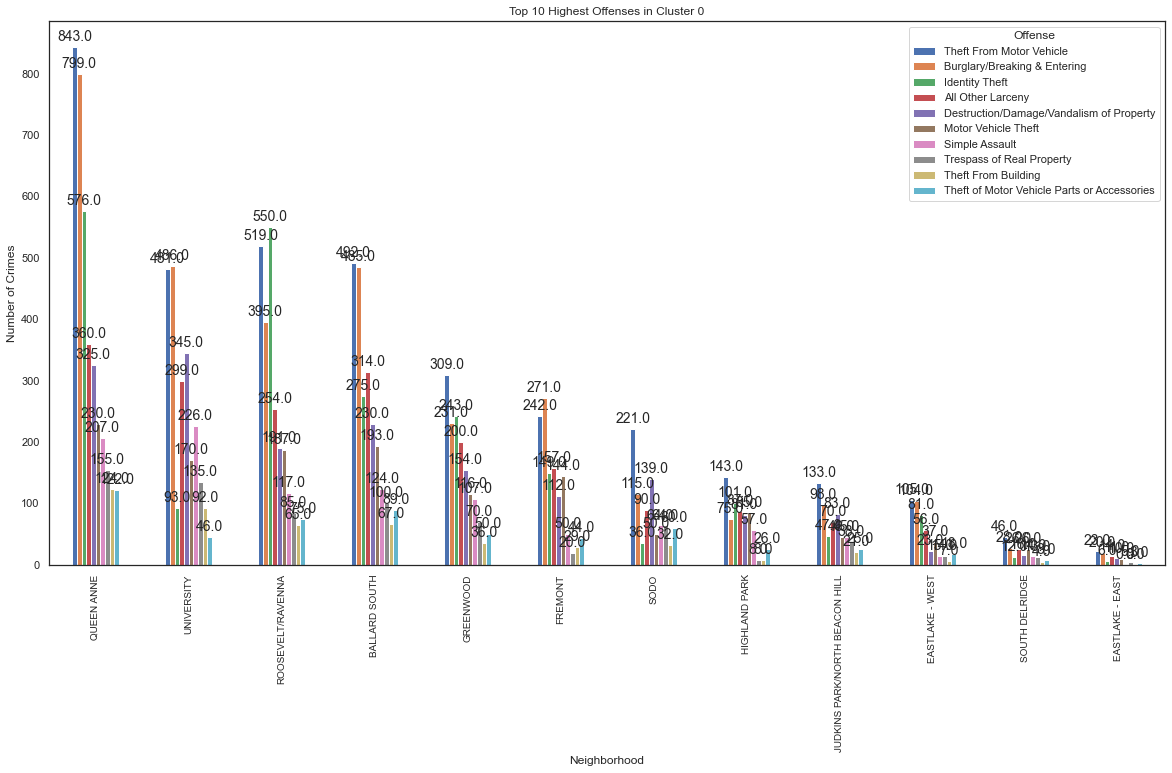

In [47]:
# visualize the top 10 highest offenses in the districts of cluster 0
ax = crime_cluster0_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Top 10 Highest Offenses in Cluster 0') # add title to the plot

# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Cluster 1

In [ ]:
# Get the districts in Cluster 1 in descending order on the count of offenses
wa_cluster[1].sort_values(ascending=False)

In [48]:
# Create chart of the top 10 crimes in each of the cluster 1 districts
cluster1districts = ["CAPITOL HILL", "DOWNTOWN COMMERCIAL", "NORTHGATE", "SLU/CASCADE", "CHINATOWN/INTERNATIONAL DISTRICT", "PIONEER SQUARE", "ROXHILL/WESTWOOD/ARBOR HEIGHTS", "MOUNT BAKER", "HIGH POINT", "RAINIER BEACH", "NEW HOLLY", "GENESEE"]
crime_cluster1 = pd.DataFrame(crime_pivot.loc[cluster1districts,:].transpose()) #slicing to get just districts in cluster 1
crime_cluster1.drop(axis=0, index=["Total"], inplace=True) #drop to Total row
crime_cluster1_sort = crime_cluster1.sort_values(by=cluster1districts, ascending=False).head(10)
crime_cluster1_plot = crime_cluster1_sort.transpose() #transpose to switch rows and columns
crime_cluster1_plot

Offense,Burglary/Breaking & Entering,Simple Assault,Destruction/Damage/Vandalism of Property,Theft From Motor Vehicle,Trespass of Real Property,Identity Theft,All Other Larceny,Shoplifting,Intimidation,Aggravated Assault
District,,,,,,,,,,
CAPITOL HILL,642.0,371.0,369.0,355.0,321.0,314.0,280.0,246.0,226.0,213.0
DOWNTOWN COMMERCIAL,391.0,545.0,340.0,518.0,466.0,240.0,270.0,699.0,255.0,279.0
NORTHGATE,384.0,196.0,261.0,480.0,166.0,398.0,333.0,372.0,151.0,91.0
SLU/CASCADE,500.0,268.0,282.0,342.0,178.0,213.0,248.0,226.0,147.0,146.0
CHINATOWN/INTERNATIONAL DISTRICT,223.0,169.0,183.0,205.0,205.0,51.0,97.0,429.0,88.0,112.0
PIONEER SQUARE,93.0,223.0,146.0,129.0,75.0,103.0,100.0,14.0,61.0,104.0
ROXHILL/WESTWOOD/ARBOR HEIGHTS,93.0,89.0,91.0,141.0,22.0,150.0,95.0,138.0,52.0,26.0
MOUNT BAKER,65.0,62.0,74.0,119.0,44.0,128.0,79.0,120.0,52.0,49.0
HIGH POINT,41.0,90.0,56.0,49.0,16.0,61.0,58.0,48.0,32.0,28.0


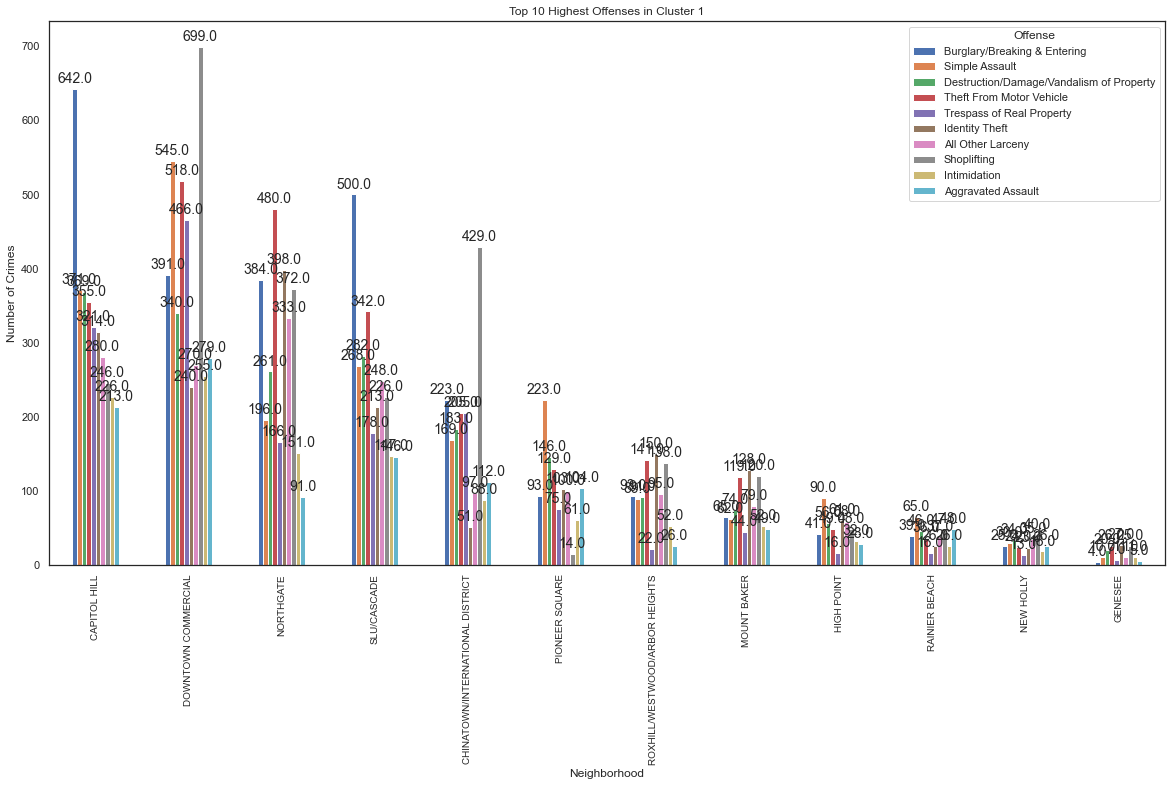

In [49]:
# visualize the top 10 highest offenses in the districts of cluster 1
ax = crime_cluster1_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Top 10 Highest Offenses in Cluster 1') # add title to the plot

# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Cluster 2

In [50]:
# Get the districts in Cluster 2 in descending order on the count of offenses
wa_cluster[2].sort_values(ascending=False)

District
FIRST HILL                  2548
LAKECITY                    1930
CENTRAL AREA/SQUIRE PARK    1869
BELLTOWN                    1762
BITTERLAKE                  1457
NORTH BEACON HILL           1313
ALASKA JUNCTION             1252
GEORGETOWN                  1003
BRIGHTON/DUNLAP              894
MID BEACON HILL              631
SOUTH PARK                   584
NORTH DELRIDGE               529
RAINIER VIEW                 528
COLUMBIA CITY                475
CLAREMONT/RAINIER VISTA      373
HILLMAN CITY                 307
SOUTH BEACON HILL            294
Name: Count of Offenses, dtype: int64

In [51]:
# Create chart of the top 10 crimes in each of the cluster 2 districts
cluster2districts = ["FIRST HILL", "LAKECITY", "CENTRAL AREA/SQUIRE PARK", "BELLTOWN", "BITTERLAKE", "NORTH BEACON HILL", "ALASKA JUNCTION", "GEORGETOWN", "BRIGHTON/DUNLAP", "MID BEACON HILL", "SOUTH PARK", "NORTH DELRIDGE", "RAINIER VIEW", "COLUMBIA CITY", "CLAREMONT/RAINIER VISTA", "HILLMAN CITY", "SOUTH BEACON HILL"]
crime_cluster2 = pd.DataFrame(crime_pivot.loc[cluster2districts,:].transpose()) #slicing to get just districts in cluster 2
crime_cluster2.drop(axis=0, index=["Total"], inplace=True) #drop to Total row
crime_cluster2_sort = crime_cluster2.sort_values(by=cluster2districts, ascending=False).head(10)
crime_cluster2_plot = crime_cluster2_sort.transpose() #transpose to switch rows and columns
crime_cluster2_plot

Offense,Burglary/Breaking & Entering,Simple Assault,Trespass of Real Property,Theft From Motor Vehicle,Destruction/Damage/Vandalism of Property,All Other Larceny,Intimidation,Identity Theft,Aggravated Assault,Theft From Building
District,,,,,,,,,,
FIRST HILL,358.0,287.0,250.0,247.0,229.0,170.0,149.0,136.0,132.0,132.0
LAKECITY,203.0,141.0,99.0,169.0,163.0,158.0,95.0,282.0,71.0,46.0
CENTRAL AREA/SQUIRE PARK,183.0,155.0,94.0,205.0,152.0,167.0,100.0,250.0,76.0,62.0
BELLTOWN,259.0,204.0,79.0,249.0,159.0,114.0,99.0,105.0,99.0,78.0
BITTERLAKE,139.0,108.0,42.0,196.0,107.0,125.0,69.0,228.0,61.0,34.0
NORTH BEACON HILL,123.0,84.0,40.0,161.0,103.0,134.0,47.0,121.0,63.0,17.0
ALASKA JUNCTION,166.0,73.0,29.0,120.0,106.0,99.0,42.0,231.0,35.0,55.0
GEORGETOWN,99.0,61.0,36.0,85.0,134.0,113.0,35.0,39.0,42.0,22.0
BRIGHTON/DUNLAP,85.0,75.0,11.0,57.0,95.0,81.0,54.0,57.0,73.0,15.0


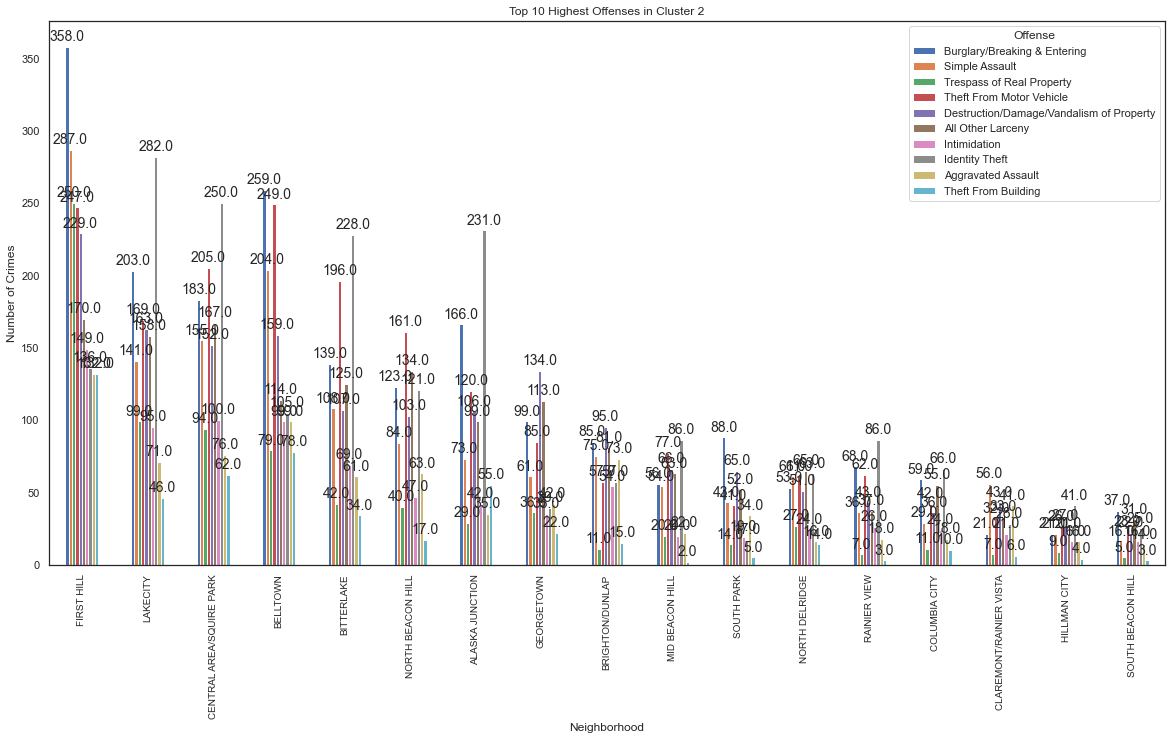

In [52]:
# visualize the top 10 highest offenses in the districts of cluster 2
ax = crime_cluster2_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Top 10 Highest Offenses in Cluster 2') # add title to the plot

# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Cluster 3

In [53]:
# Get the districts in Cluster 3 in descending order on the count of offenses
wa_cluster[3].sort_values(ascending=False)

District
SANDPOINT               2261
BALLARD NORTH           1752
MAGNOLIA                1489
WALLINGFORD             1385
MADRONA/LESCHI           913
UNKNOWN                  900
NORTH ADMIRAL            792
MORGAN                   791
PHINNEY RIDGE            741
MILLER PARK              562
MONTLAKE/PORTAGE BAY     532
FAUNTLEROY SW            395
LAKEWOOD/SEWARD PARK     374
ALKI                     373
MADISON PARK             320
PIGEON POINT              86
Name: Count of Offenses, dtype: int64

In [54]:
# Create chart of the top 10 crimes in each of the cluster 3 districts
cluster3districts = ["SANDPOINT", "BALLARD NORTH", "MAGNOLIA", "WALLINGFORD", "MADRONA/LESCHI", "NORTH ADMIRAL", "MORGAN", "PHINNEY RIDGE", "MILLER PARK", "MONTLAKE/PORTAGE BAY", "FAUNTLEROY SW", "LAKEWOOD/SEWARD PARK", "ALKI", "MADISON PARK", "PIGEON POINT"]
crime_cluster3 = pd.DataFrame(crime_pivot.loc[cluster3districts,:].transpose()) #slicing to get just districts in cluster 3
crime_cluster3.drop(axis=0, index=["Total"], inplace=True) #drop to Total row
crime_cluster3_sort = crime_cluster3.sort_values(by=cluster3districts, ascending=False).head(10)
crime_cluster3_plot = crime_cluster3_sort.transpose() #transpose to switch rows and columns
crime_cluster3_plot

Offense,Identity Theft,Theft From Motor Vehicle,Burglary/Breaking & Entering,All Other Larceny,Destruction/Damage/Vandalism of Property,Motor Vehicle Theft,Simple Assault,Intimidation,Theft of Motor Vehicle Parts or Accessories,Aggravated Assault
District,,,,,,,,,,
SANDPOINT,779.0,369.0,190.0,179.0,125.0,110.0,89.0,64.0,44.0,44.0
BALLARD NORTH,528.0,257.0,165.0,151.0,112.0,124.0,54.0,38.0,52.0,23.0
MAGNOLIA,348.0,251.0,168.0,112.0,109.0,106.0,64.0,53.0,40.0,35.0
WALLINGFORD,316.0,228.0,226.0,114.0,80.0,121.0,33.0,33.0,57.0,18.0
MADRONA/LESCHI,180.0,146.0,66.0,82.0,54.0,53.0,50.0,42.0,14.0,28.0
NORTH ADMIRAL,229.0,68.0,69.0,64.0,49.0,55.0,42.0,27.0,27.0,7.0
MORGAN,204.0,108.0,66.0,59.0,64.0,87.0,24.0,30.0,19.0,18.0
PHINNEY RIDGE,201.0,149.0,86.0,65.0,54.0,53.0,15.0,9.0,27.0,12.0
MILLER PARK,131.0,89.0,68.0,46.0,37.0,28.0,25.0,19.0,12.0,15.0


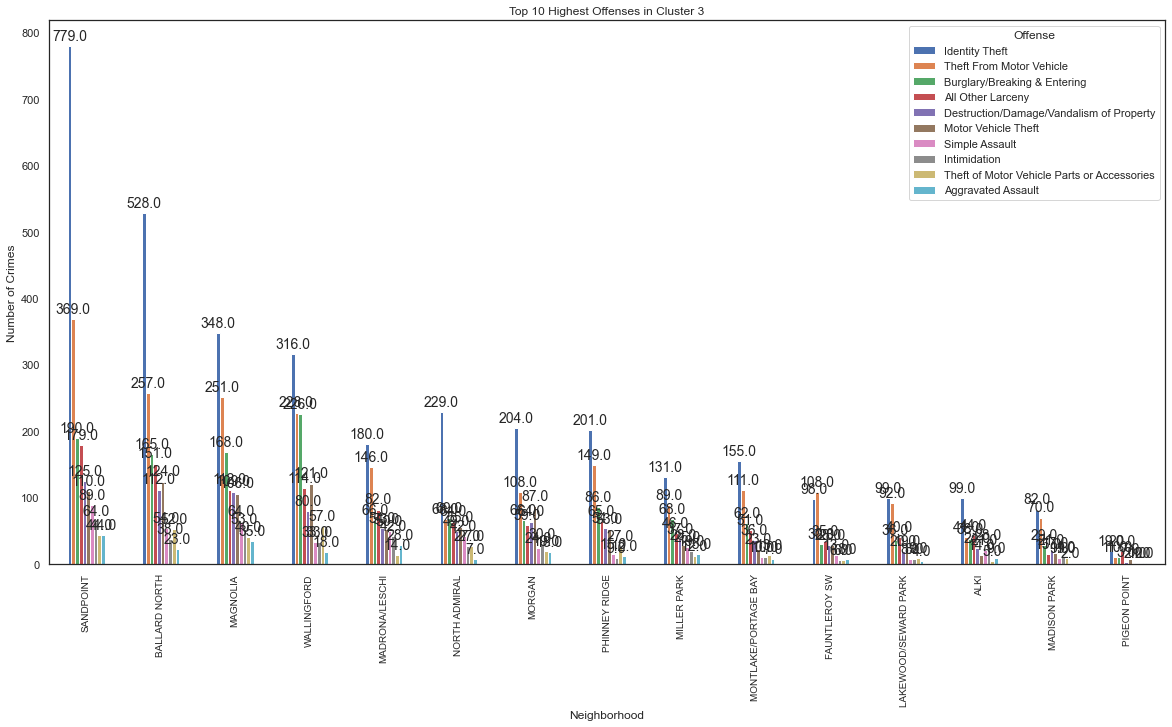

In [55]:
# visualize the top 10 highest offenses in the districts of cluster 3
ax = crime_cluster3_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Top 10 Highest Offenses in Cluster 3') # add title to the plot

# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Cluster 4

In [56]:
# Get the districts in Cluster 4 in descending order on the count of offenses
wa_cluster[4].sort_values(ascending=False)

District
COMMERCIAL DUWAMISH         49
COMMERCIAL HARBOR ISLAND    35
Name: Count of Offenses, dtype: int64

In [57]:
# Create chart of the top 10 crimes in each of the cluster 4 districts
cluster4districts = ["COMMERCIAL DUWAMISH", "COMMERCIAL HARBOR ISLAND"]
crime_cluster4 = pd.DataFrame(crime_pivot.loc[cluster4districts,:].transpose()) #slicing to get just districts in cluster 4
crime_cluster4.drop(axis=0, index=["Total"], inplace=True) #drop to Total row
crime_cluster4_sort = crime_cluster4.sort_values(by=cluster4districts, ascending=False).head(10)
crime_cluster4_plot = crime_cluster4_sort.transpose() #transpose to switch rows and columns
crime_cluster4_plot

Offense,Burglary/Breaking & Entering,Driving Under the Influence,All Other Larceny,Theft of Motor Vehicle Parts or Accessories,Aggravated Assault,Destruction/Damage/Vandalism of Property,Theft From Motor Vehicle,Motor Vehicle Theft,Trespass of Real Property,Identity Theft
District,,,,,,,,,,
COMMERCIAL DUWAMISH,9.0,7.0,6.0,5.0,4.0,4.0,3.0,2.0,2.0,1.0
COMMERCIAL HARBOR ISLAND,2.0,9.0,7.0,NaN,3.0,3.0,2.0,3.0,NaN,1.0


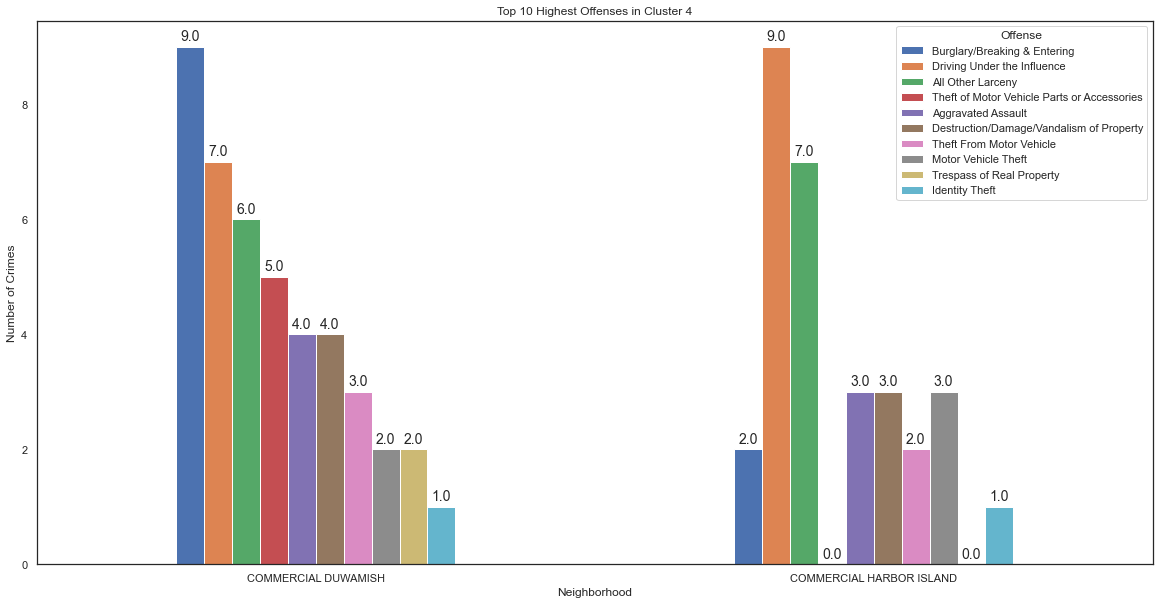

In [58]:
# visualize the top 10 highest offenses in the districts of cluster 4
ax = crime_cluster4_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighborhood') # add y-label to the plot
ax.set_title('Top 10 Highest Offenses in Cluster 4') # add title to the plot

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

#### Since Clusters 0, 1, and 2 contain districts that are in the list of top 10 districts with the most total crimes, and Cluster 4 only contains commercial districts (not districts for living in), this narrows down our search for a suitable place to live to just Cluster 3. 

## 6. Explore the neighborhoods within the districts of Cluster 3
Since the districts in cluster 3 have been chosen as the safer part of Seattle to live in, we would now like to take a closer look the neighborhoods within these districts. We want to look at the venues in the neighborhoods using the Foursquare API and to narrow down our search for the most suitable neighborhood to live in. 

First we will get the neighborhoods that are within the districts of Cluster 3, along with their coordinates, and put them into a pandas dataframe. Districts that don't have any neighborhoods will have the district name be the neighborhood name.

In [59]:
# manually cleaned up the district names to more accurately match the districts in wa_data
cluster3districts_rev = ["SANDPOINT", "NORTH BALLARD", "MAGNOLIA", "WALLINGFORD", "MADRONA", "LESCHI", "NORTH ADMIRAL", "MORGAN", "PHINNEY RIDGE", "MILLER PARK", "MONTLAKE", "PORTAGE BAY", "FAUNTLEROY", "LAKEWOOD", "SEWARD PARK", "ALKI", "MADISON PARK", "PIGEON POINT"]
# creates an "or" series of the list cluster3districts_rev
search_list = '|'.join(cluster3districts_rev)

# convert each series in Neighborhood and District column to uppercase
wa_data["Neighborhood"] = wa_data["Neighborhood"].str.upper()
wa_data["District"] = wa_data["District"].str.upper()

# check the datatypes in each column
print(wa_data.dtypes)
# check that it worked
wa_data.head()

Neighborhood     object
District         object
Latitude        float64
Longitude       float64
dtype: object


,Neighborhood,District,Latitude,Longitude
0,NEIGHBORHOOD,DISTRICT,12.516990,123.749150
1,NORTH SEATTLE,SEATTLE,47.643724,-122.302937
2,BROADVIEW,NORTH SEATTLE,47.722380,-122.364980
3,BITTER LAKE,NORTH SEATTLE,47.718680,-122.350300
4,NORTH BEACH / BLUE RIDGE,NORTH SEATTLE,47.700440,-122.384180


In [60]:
# finds all the rows where search_list matches an item in the Neighborhood column
wa_data_temp1 = wa_data[wa_data["Neighborhood"].str.contains(search_list)]
wa_data_temp1

,Neighborhood,District,Latitude,Longitude
29,WALLINGFORD,NORTH SEATTLE,47.655550,-122.326500
33,PHINNEY RIDGE,NORTH SEATTLE,47.675960,-122.354360
41,MAGNOLIA,CENTRAL SEATTLE,40.728460,-89.441610
44,SOUTHEAST MAGNOLIA,MAGNOLIA,47.641170,-122.391770
52,PORTAGE BAY,CAPITOL HILL,47.646900,-122.320280
55,MONTLAKE,CAPITOL HILL,47.640850,-122.302070
60,MADISON PARK,CAPITOL HILL,47.635010,-122.278600
84,MADRONA,CENTRAL AREA,47.612930,-122.289680
85,MADRONA VALLEY,MADRONA,46.905066,-122.383706
88,LESCHI,CENTRAL AREA,47.601500,-122.291340


In [61]:
# finds all the rows where search_list matches an item in the District column
wa_data_temp2 = wa_data[wa_data["District"].str.contains(search_list)]
wa_data_temp2

,Neighborhood,District,Latitude,Longitude
30,NORTHLAKE,"LAKE UNION / LOWER WALLINGFORD, SPILLING OVER ...",48.486180,-120.590000
42,LAWTON PARK,MAGNOLIA,47.659080,-122.400920
43,BRIARCLIFF,MAGNOLIA,47.645000,-122.407740
44,SOUTHEAST MAGNOLIA,MAGNOLIA,47.641170,-122.391770
61,BROADMOOR,MADISON PARK,47.632820,-122.288270
85,MADRONA VALLEY,MADRONA,46.905066,-122.383706
99,LAKEWOOD,SEWARD PARK,47.161950,-122.514930


In [62]:
# combine the 2 dataframes, drop the duplicate rows, and reset the index
cluster3_data = pd.concat([wa_data_temp1, wa_data_temp2]).drop_duplicates().reset_index(drop=True)
cluster3_data

,Neighborhood,District,Latitude,Longitude
0,WALLINGFORD,NORTH SEATTLE,47.655550,-122.326500
1,PHINNEY RIDGE,NORTH SEATTLE,47.675960,-122.354360
2,MAGNOLIA,CENTRAL SEATTLE,40.728460,-89.441610
3,SOUTHEAST MAGNOLIA,MAGNOLIA,47.641170,-122.391770
4,PORTAGE BAY,CAPITOL HILL,47.646900,-122.320280
5,MONTLAKE,CAPITOL HILL,47.640850,-122.302070
6,MADISON PARK,CAPITOL HILL,47.635010,-122.278600
7,MADRONA,CENTRAL AREA,47.612930,-122.289680
8,MADRONA VALLEY,MADRONA,46.905066,-122.383706
9,LESCHI,CENTRAL AREA,47.601500,-122.291340


### Now that have a dataframe containing all the neighborhoods of Cluster 3, we want to look at the venues nearby them.

#### Define Foursquare credentials and version

In [63]:
CLIENT_ID = 'VH5TEQNZDJXUGSTJCJHLWJ24S1FP3QKGMOZZD5CBTHBVBDCI' # your Foursquare ID
CLIENT_SECRET = 'Q43IQED1LNI1OPJIVE3MNRDKYN2NUWI4UONA0L0QDARYAUMO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: VH5TEQNZDJXUGSTJCJHLWJ24S1FP3QKGMOZZD5CBTHBVBDCI
CLIENT_SECRET:Q43IQED1LNI1OPJIVE3MNRDKYN2NUWI4UONA0L0QDARYAUMO


#### Define a function that gets the top 100 venues within a radius of 1609 meters (~ 1 mile).

In [64]:
def getNearbyVenues(names, latitudes, longitudes, radius=1609, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Use the getNearbyVenues function on each neighborhood and create a new dataframe called cluster3_venues

In [65]:
wa_venues = getNearbyVenues(names=cluster3_data['Neighborhood'],
                                   latitudes=cluster3_data['Latitude'],
                                   longitudes=cluster3_data['Longitude']
                                  )

WALLINGFORD
PHINNEY RIDGE
MAGNOLIA
SOUTHEAST MAGNOLIA
PORTAGE BAY
MONTLAKE
MADISON PARK
MADRONA
MADRONA VALLEY
LESCHI
SEWARD PARK
LAKEWOOD
ALKI POINT
NORTH ADMIRAL
FAUNTLEROY
PIGEON POINT
NORTHLAKE
LAWTON PARK
BRIARCLIFF
BROADMOOR


#### Let's check the size of the resulting dataframe.

In [66]:
print(wa_venues.shape)
wa_venues.head()

(1247, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,WALLINGFORD,47.65555,-122.3265,Westward,47.651678,-122.328912,Seafood Restaurant
1,WALLINGFORD,47.65555,-122.3265,Burke-Gilman Trail,47.655589,-122.320598,Park
2,WALLINGFORD,47.65555,-122.3265,Ivar's Salmon House,47.653525,-122.323832,Seafood Restaurant
3,WALLINGFORD,47.65555,-122.3265,Ivars Fish Bar,47.653859,-122.323933,Seafood Restaurant
4,WALLINGFORD,47.65555,-122.3265,Voula's Offshore Cafe,47.654709,-122.321634,Diner


#### Let's check how many venues were returned for each neighborhood

In [67]:
wa_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ALKI POINT,39,39,39,39,39,39
BRIARCLIFF,37,37,37,37,37,37
BROADMOOR,85,85,85,85,85,85
FAUNTLEROY,28,28,28,28,28,28
LAKEWOOD,100,100,100,100,100,100
LAWTON PARK,96,96,96,96,96,96
LESCHI,100,100,100,100,100,100
MADISON PARK,52,52,52,52,52,52
MADRONA,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [68]:
print('There are {} unique categories.'.format(len(wa_venues['Venue Category'].unique())))

There are 226 unique categories.


#### Let's see a map of where all these venues are.

In [69]:
# Create map of King County using latitude and longitude values
map_cluster3venues = folium.Map(location=[latitude_seattle, longitude_seattle], zoom_start=10)

# add markers to map
for lat, lng, category, name in zip(wa_venues['Venue Latitude'], wa_venues['Venue Longitude'], wa_venues['Venue Category'], wa_venues['Venue']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#ffff00',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster3venues)  
    
map_cluster3venues

In [70]:
wa_venues['Venue Category'].unique()

array(['Seafood Restaurant', 'Park', 'Diner', 'Poke Place',
       'Mediterranean Restaurant', 'Eastern European Restaurant',
       'Burger Joint', 'Bookstore', 'Food Truck', 'Bar',
       'Fried Chicken Joint', 'Café', 'Arts & Crafts Store',
       'Asian Restaurant', 'Italian Restaurant', 'Sushi Restaurant',
       'Taco Place', 'Breakfast Spot', 'Restaurant', 'Bakery', 'Dive Bar',
       'Pet Store', 'Cupcake Shop', 'Lounge', 'Movie Theater', 'Brewery',
       'Ice Cream Shop', 'Thai Restaurant', 'Grocery Store',
       'Vietnamese Restaurant', 'Clothing Store', 'Coffee Shop',
       'Beer Store', 'Mexican Restaurant', 'Deli / Bodega',
       'Japanese Restaurant', 'Harbor / Marina', 'Video Game Store',
       'Video Store', 'American Restaurant', 'Pizza Place',
       'Korean Restaurant', 'Board Shop', 'Wine Bar', 'Music Venue',
       'New American Restaurant', 'Cuban Restaurant', 'Sandwich Place',
       'South American Restaurant', 'Pub', 'Yoga Studio',
       'Toy / Game Store

### Now let's analyze each neighborhood in Cluster 3, according to the venues

In [71]:
# one hot encoding
wa3_onehot = pd.get_dummies(wa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column to the dataframe as the first column
wa3_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True) #troubleshooting
wa3_onehot.insert(0, 'Neighborhood', wa_venues["Neighborhood"])

wa3_onehot.head()

,Neighborhood,ATM,African Restaurant,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bay,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Theater,Convenience Store,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,High School,Historic Site,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lawyer,Library,Lighthouse,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nature Preserve,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Record Shop,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Ski Area,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Travel Agency,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,WALLINGFORD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,WALLINGFORD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [72]:
wa3_onehot.shape

(1247, 226)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [73]:
wa3_grouped = wa3_onehot.groupby('Neighborhood').mean().reset_index()
wa3_grouped

,Neighborhood,ATM,African Restaurant,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bay,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Theater,Convenience Store,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,High School,Historic Site,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lawyer,Library,Lighthouse,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nature Preserve,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Record Shop,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Ski Area,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Travel Agency,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,ALKI POINT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.025641,0.000000,0.102564,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.00,0.025641,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.025641,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000

Let's confirm the new size.

In [74]:
wa3_grouped.shape

(18, 226)

#### Let's print each neighborhood along with the top 5 most common venues

In [75]:
num_top_venues = 5

for hood in wa3_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = wa3_grouped[wa3_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALKI POINT----
                venue  freq
0               Beach  0.10
1         Coffee Shop  0.08
2      Ice Cream Shop  0.08
3  Italian Restaurant  0.08
4                Park  0.08


----BRIARCLIFF----
         venue  freq
0         Park  0.16
1   Playground  0.11
2  Coffee Shop  0.05
3  Pizza Place  0.05
4        Trail  0.05


----BROADMOOR----
    venue  freq
0    Park  0.08
1  Bakery  0.04
2   Trail  0.04
3  Garden  0.04
4     Bar  0.04


----FAUNTLEROY----
               venue  freq
0               Park  0.25
1               Pool  0.07
2      Boat or Ferry  0.07
3             Market  0.07
4  Convenience Store  0.07


----LAKEWOOD----
                  venue  freq
0           Pizza Place  0.06
1  Fast Food Restaurant  0.05
2        Sandwich Place  0.04
3    Mexican Restaurant  0.04
4           Coffee Shop  0.04


----LAWTON PARK----
          venue  freq
0  Cocktail Bar  0.05
1   Coffee Shop  0.05
2           Bar  0.05
3          Park  0.04
4         Trail  0.03


----LESCHI--

#### Let's put this into a pandas dataframe to make it easier to read.

But first, let's define a function that will sort the venues in descending order.

In [76]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we can create the dataframe that displays the top 10 venues for each neighborhood.

In [77]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
wa3_neigh_venues_sorted = pd.DataFrame(columns=columns)
wa3_neigh_venues_sorted['Neighborhood'] = wa3_grouped['Neighborhood']

for ind in np.arange(wa3_grouped.shape[0]):
    wa3_neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wa3_grouped.iloc[ind, :], num_top_venues)

wa3_neigh_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALKI POINT,Beach,Park,Coffee Shop,Ice Cream Shop,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Donut Shop,Sandwich Place,Scenic Lookout
1,BRIARCLIFF,Park,Playground,Bank,Trail,Coffee Shop,Pharmacy,Pizza Place,Dog Run,Mexican Restaurant,Farmers Market
2,BROADMOOR,Park,Italian Restaurant,Garden,Bar,Bakery,Trail,French Restaurant,Café,Soccer Field,Pizza Place
3,FAUNTLEROY,Park,Market,Boat or Ferry,Convenience Store,Pool,Botanical Garden,Coffee Shop,Sports Bar,Taco Place,Beer Store
4,LAKEWOOD,Pizza Place,Fast Food Restaurant,Sandwich Place,Coffee Shop,Mexican Restaurant,Clothing Store,Gym / Fitness Center,Burger Joint,Ice Cream Shop,Salon / Barbershop
5,LAWTON PARK,Coffee Shop,Bar,Cocktail Bar,Park,Mexican Restaurant,Pizza Place,Brewery,Trail,Ice Cream Shop,Clothing Store
6,LESCHI,Coffee Shop,Ethiopian Restaurant,Park,Playground,Bar,Grocery Store,Pizza Place,Café,Vietnamese Restaurant,Gift Shop
7,MADISON PARK,Park,Café,Bar,Garden,Trail,Scenic Lookout,Pizza Place,Bank,Bakery,Soccer Field
8,MADRONA,Coffee Shop,Park,Ethiopian Restaurant,Playground,Thai Restaurant,Café,French Restaurant,Italian Restaurant,Food Truck,Bar
9,MAGNOLIA,Physical Therapist,American Restaurant,Hotel,Food,Furniture / Home Store,Park,Entertainment Service,Dry Cleaner,Eastern European Restaurant,Electronics Store


#### By investigating the venues in the neighborhoods of Cluster 3, I have further narrowed down my search for a suitable place to Broadmoor, because of its proximity to a park and italian restaurants. 